In [38]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as DT
sns.set(rc={'figure.figsize':(11.7,8.27)})
sys.path.append('..')
import rbf_functions

In [45]:
rbfs = [rbf_functions.original_rbf,
        rbf_functions.squared_exponential_rbf,
        rbf_functions.inverse_quadratic_rbf,
        rbf_functions.inverse_multiquadric_rbf,
        rbf_functions.exponential_rbf,
        rbf_functions.matern32_rbf,
        rbf_functions.matern52_rbf,
       ]

nfearchive = {}
for n in rbfs:
    nfearchive[n.__name__] = {}
for entry in rbfs:
    name = entry.__name__
    output_dir = f"../output/{name}/"
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume.csv"):
            archives_by_nfe = pd.read_csv(output_dir + i)
            nfes = archives_by_nfe["Unnamed: 0"].values
            u_nfes = np.unique(nfes)
            selected_nfe = u_nfes
#             selected_nfe = u_nfes[0::5]
#             selected_nfe = np.append(selected_nfe, u_nfes[-1::])
            nfearchive[name][int(i.split("_")[0])] = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe)]

In [46]:
from platypus import Solution, Problem, EpsilonIndicator

n_rbfs = 4
n_objs = 6
n_vars = n_rbfs * 8 

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MAXIMIZE  # hydropower
problem.directions[1] = Problem.MAXIMIZE  # atomic power plant
problem.directions[2] = Problem.MAXIMIZE  # baltimore
problem.directions[3] = Problem.MAXIMIZE  # chester
problem.directions[4] = Problem.MINIMIZE  # environment
problem.directions[5] = Problem.MAXIMIZE  # recreation

archives = {}
seeds = np.arange(10, 101, 10).tolist()
for n in rbfs:
    archives[n.__name__] = {}
    for i in seeds:
        archives[n.__name__][i] = {}
for entry in rbfs:
    name = entry.__name__
    for s in nfearchive[name]: #nfearchive[name]:
        for nfe, generation in nfearchive[name][s].groupby("Unnamed: 0"):
            # we slice from 2, getting rid of the first two columns 
            # which contain the NFE and ID of each solution
            archive = []
            for i, row in generation.iloc[:, 2::].iterrows():
                solution = Solution(problem)
                solution.objectives = row
                archive.append(solution)
            archives[name][s][nfe] = archive
        

In [47]:
ref_dir = "../refsets/"
ref_sets = {}
for n in rbfs:
    name = n.__name__
    ref_sets[name] = {}
    data = pd.read_csv(f'{ref_dir}{name}_refset.csv')  
    ref_set = []
    for i, row in data.iterrows():
        solution = Solution(problem)
        solution.objectives = row
        ref_set.append(solution)
    ref_sets[name] = ref_set

In [24]:
archives.keys()

dict_keys(['original_rbf', 'squared_exponential_rbf', 'inverse_quadratic_rbf', 'inverse_multiquadric_rbf', 'exponential_rbf', 'matern32_rbf', 'matern52_rbf'])

In [48]:
# ei = EpsilonIndicator(reference_set=ref_set)
# nfes = []
# eis = []
# for nfe, archive in archives.items():
#     nfes.append(nfe)
#     eis.append(ei.calculate(archive))

# rbf = "inverse_multiquadric_rbf"
tempnfe = {}
tempei = {}
nfe_sets = {}
ei_sets = {}
for rbf in archives:
    nfe_sets[rbf] = {}
    ei_sets[rbf] = {}
    ei = EpsilonIndicator(reference_set=ref_sets[rbf])
    print(f"started {rbf} at {DT.datetime.now()}")
    for seed in archives[rbf]:
        nfe_sets[rbf][seed] = {}
        ei_sets[rbf][seed] = {}
        s_archives = archives[rbf][seed]
        nfes = []
        eis = []
        for nfe, archive in s_archives.items():
            nfes.append(nfe)
            eis.append(ei.calculate(archive))
        nfe_sets[rbf][seed] = nfes
        ei_sets[rbf][seed] = eis
        tempnfe[seed] = nfes
        tempei[seed] = eis
        dfei = pd.DataFrame.from_dict(tempei, orient='index')
        dfnfe = pd.DataFrame.from_dict(tempnfe, orient='index')
        dfei = dfei.T
        dfnfe = dfnfe.T
        dfei.to_csv(f"epind/{rbf}_ei.csv", index=False)
        dfnfe.to_csv(f"epind/{rbf}_ei_nfe.csv", index=False)
        print(f"finished seed: {seed} at {DT.datetime.now()}")

started original_rbf at 2022-01-08 02:38:21.882270
finished seed: 10 at 2022-01-08 02:41:14.046228
finished seed: 20 at 2022-01-08 02:43:34.347038
finished seed: 30 at 2022-01-08 02:46:52.618581
finished seed: 40 at 2022-01-08 02:50:11.147319
finished seed: 50 at 2022-01-08 02:52:47.655254
finished seed: 60 at 2022-01-08 02:55:56.759997
finished seed: 70 at 2022-01-08 02:58:42.677899
finished seed: 80 at 2022-01-08 03:00:57.522099
finished seed: 90 at 2022-01-08 03:03:57.072813
finished seed: 100 at 2022-01-08 03:07:01.877734
started squared_exponential_rbf at 2022-01-08 03:07:01.918130
finished seed: 10 at 2022-01-08 03:08:52.646949
finished seed: 20 at 2022-01-08 03:11:45.250248
finished seed: 30 at 2022-01-08 03:13:12.177423
finished seed: 40 at 2022-01-08 03:15:23.435726
finished seed: 50 at 2022-01-08 03:17:35.830886
finished seed: 60 at 2022-01-08 03:20:15.222272
finished seed: 70 at 2022-01-08 03:23:17.612399
finished seed: 80 at 2022-01-08 03:25:25.849671
finished seed: 90 at 2

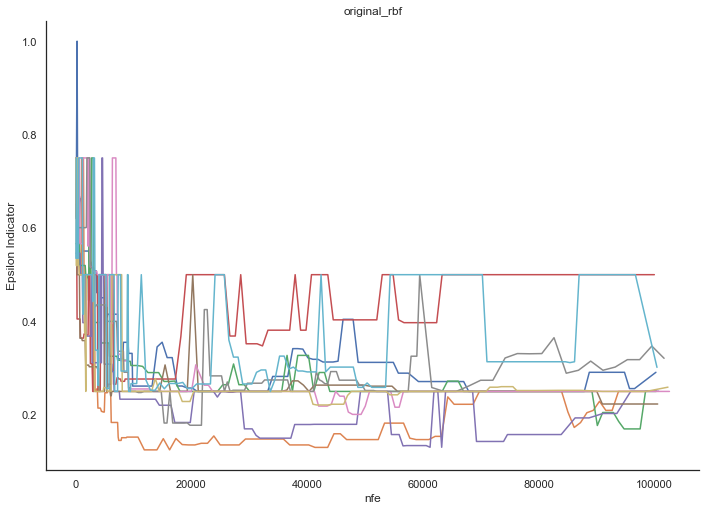

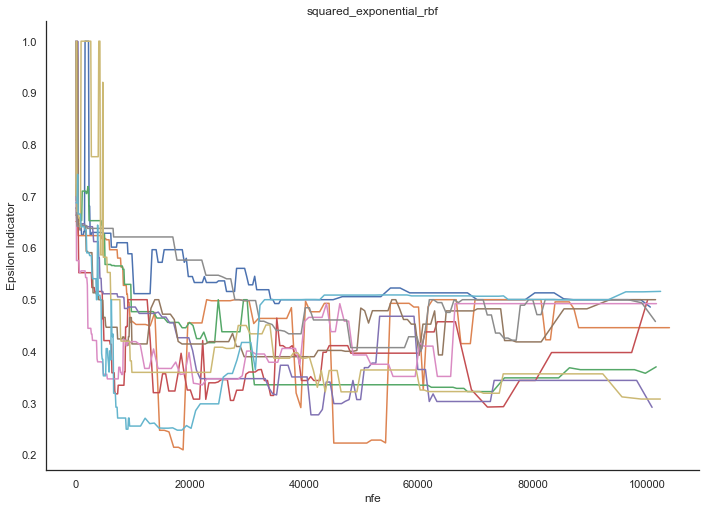

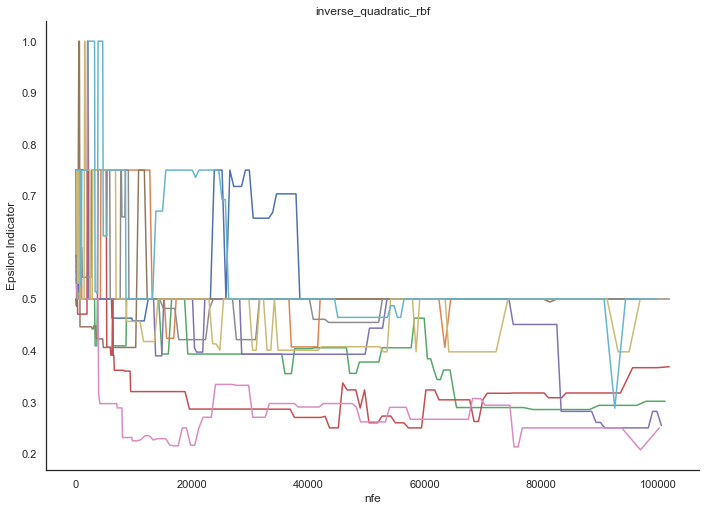

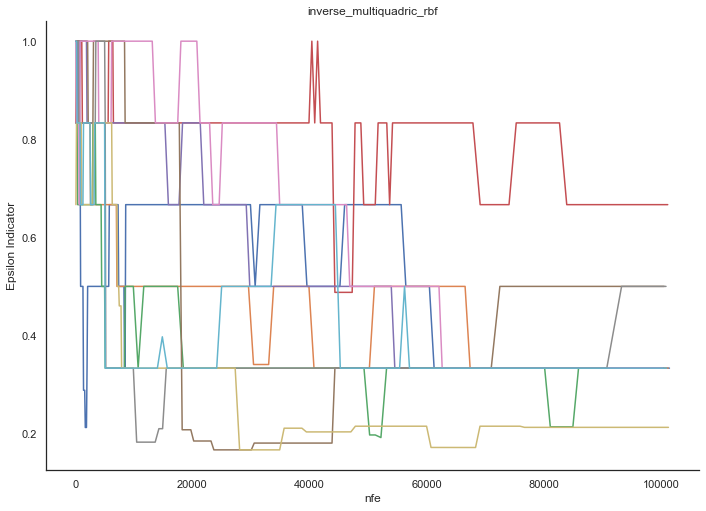

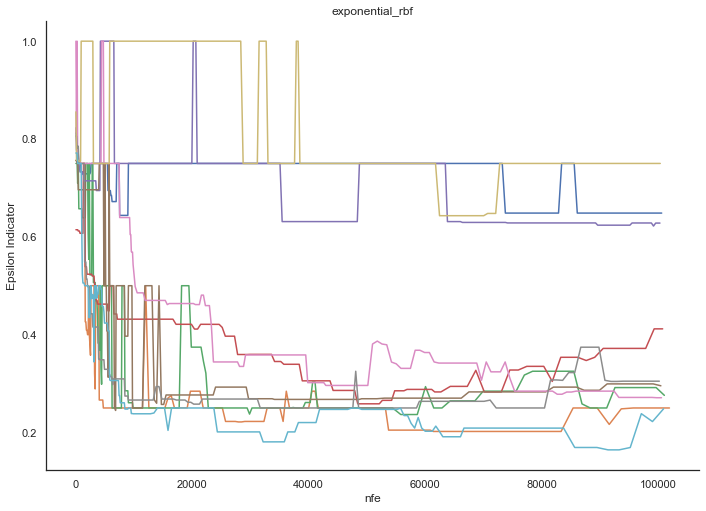

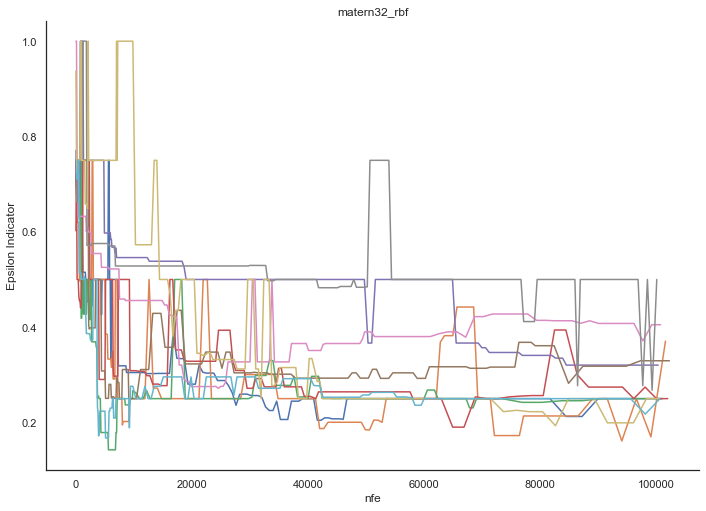

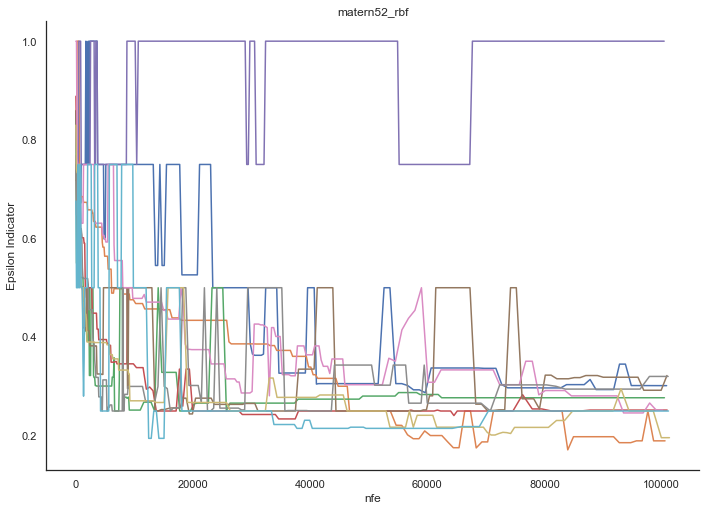

In [49]:
sns.set_style("white")
for entry in rbfs:
    name = entry.__name__
    ei = pd.DataFrame.from_dict(ei_sets[name], orient='index').T
    nfe = pd.DataFrame.from_dict(nfe_sets[name], orient='index').T
    
    fig, ax = plt.subplots()
    ax.plot(nfe, ei)
    ax.set_xlabel('nfe')
    ax.set_ylabel('Epsilon Indicator')
    ax.set_title(name)
    sns.despine()

    plt.show()

In [10]:
from platypus import Spacing

sp = Spacing()
nfes = []
sps = []
for nfe, archive in archives.items():
    nfes.append(nfe)
    sps.append(sp.calculate(archive))

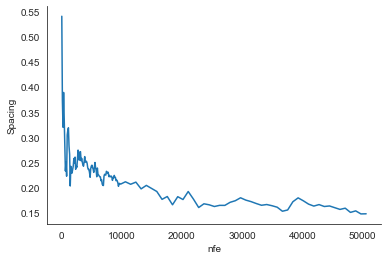

In [11]:
sns.set_style("white")

fig, ax = plt.subplots()

ax.plot(nfes, sps)
ax.set_xlabel('nfe')
ax.set_ylabel('Spacing')

sns.despine()

plt.show()